[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mukul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mukul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mukul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mukul\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
C:\Users\mukul\AppData\Local\Temp\ipykernel_18036\3074629902.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

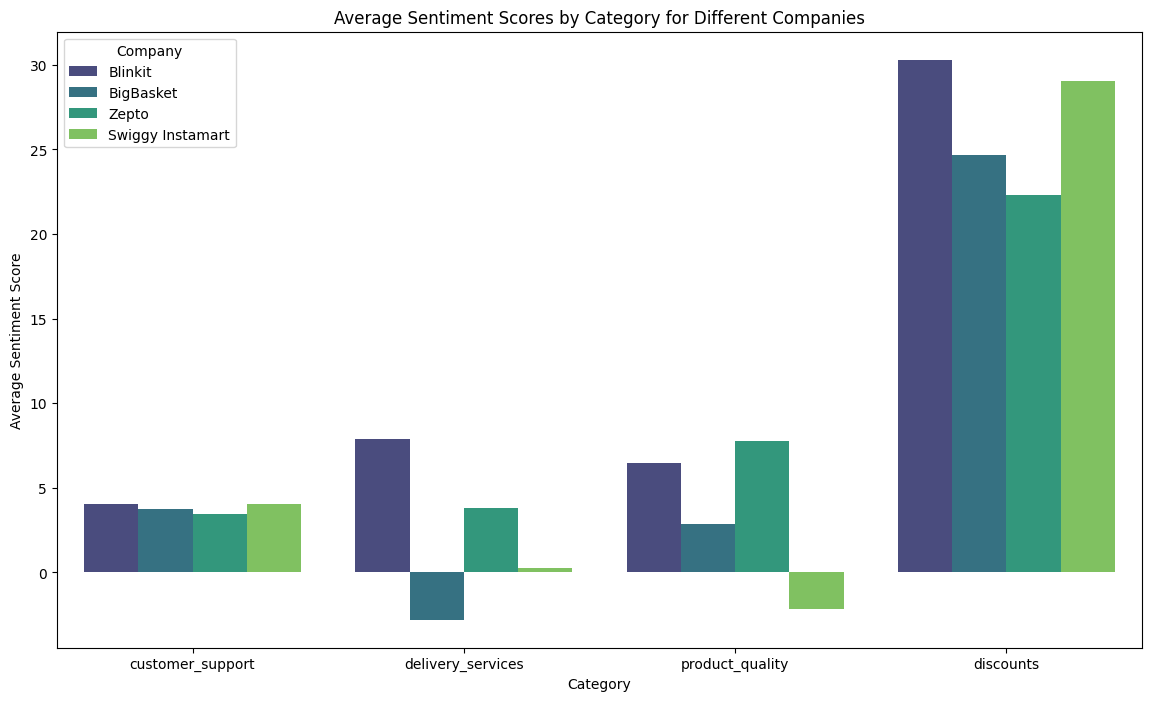

In [1]:
import pandas as pd
import re
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Ensure the required NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Initialize necessary objects
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
analyzer = SentimentIntensityAnalyzer()

# Function to remove emojis from the text
def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F700-\U0001F77F"  # alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251" 
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Additional words to remove
additional_words_to_remove = set(["blinkit", "zepto", "bigbasket", "swiggy instamart", "zomato", "swiggy","swiggycares","bigbasketcom","dunzo","jiomart",
                                  "instamart" ,"dmart","big", "basket","flipkart"])

# Data processing function
def data_processing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+', ' ', text)  # Replace mentions with whitespace
    text = re.sub(r'[^\w\s#]', '', text)  # Remove punctuation, including apostrophes
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = remove_emojis(text)  # Remove emojis
    text_tokens = word_tokenize(text)

    # Filter out tokens that are stop words
    text_tokens = [w for w in text_tokens if w not in stop_words]
    
    # Filter out tokens that contain any of the additional words to remove as substrings
    text_tokens = [w for w in text_tokens if not any(word in w for word in additional_words_to_remove)]
    
    return " ".join(text_tokens)

# Function to get the part of speech for lemmatization
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Lemmatization function
def lemmatization(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    return ' '.join(lemmatized_words)

# Function to check for keywords in text
def check_keywords(text, keywords):
    for keyword in keywords:
        if keyword in text:
            return True
    return False

# Function to perform sentiment analysis using VADER
def polarity(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']

# Function to process and analyze the data
def process_and_analyze_data(file_path, company_name):
    df = pd.read_csv(file_path)
    df['processed_text'] = df['text'].apply(data_processing)
    df['processed_text'] = df['processed_text'].apply(lemmatization)
    df = df.dropna(subset=['processed_text'])
    df = df[df['processed_text'].str.strip().astype(bool)]
    
    # Expanded keywords dictionary
    keywords = {
        'customer_support': ['customer support', 'support', 'help', 'assistance', 'customer care', 'complaint', 'resolution', 'query', 'live chat', 'support team', 'call center', 'issue','call','money','refund','reply','response','resolve','resolved','email'],
        'delivery_services': ['deliver','hour','minute','delivery','cancel', 'ship', 'arrive', 'courier', 'fast delivery', 'late delivery', 'on-time delivery', 'delivery time', 'delivery service', 'express delivery', 'next day delivery', 'same day delivery', 'contactless delivery','time','receive','quick'],
        'product_quality': ['quality', 'defective', 'satisfied', 'unsatisfied', 'poor', 'excellent', 'high quality', 'low quality', 'durable', 'broken', 'faulty', 'fresh', 'rotten', 'expiry', 'damaged', 'premium quality', 'organic', 'branded','like','dislike','product','return','good quality','bad quality','miss','spolied','spoilt','expire','cold'],
        'discounts': ['discount', 'offer', 'sale', 'promotion', 'deal', 'coupon', 'voucher', 'savings', 'markdown', 'cashback', 'special offer', 'buy one get one', 'limited time offer','price','free','mrp']
    }
    
    # Create separate DataFrames based on the presence of keywords
    df_customer_support = df[df['processed_text'].apply(lambda x: check_keywords(x, keywords['customer_support']))]
    df_delivery_services = df[df['processed_text'].apply(lambda x: check_keywords(x, keywords['delivery_services']))]
    df_product_quality = df[df['processed_text'].apply(lambda x: check_keywords(x, keywords['product_quality']))]
    df_discounts = df[df['processed_text'].apply(lambda x: check_keywords(x, keywords['discounts']))]
    
    # Perform sentiment analysis
    df_customer_support['sentiment'] = df_customer_support['processed_text'].apply(polarity)
    df_delivery_services['sentiment'] = df_delivery_services['processed_text'].apply(polarity)
    df_product_quality['sentiment'] = df_product_quality['processed_text'].apply(polarity)
    df_discounts['sentiment'] = df_discounts['processed_text'].apply(polarity)
    
    # Calculate average sentiment scores
    average_sentiments = {
        'customer_support': df_customer_support['sentiment'].mean() * 100,
        'delivery_services': df_delivery_services['sentiment'].mean() * 100,
        'product_quality': df_product_quality['sentiment'].mean() * 100,
        'discounts': df_discounts['sentiment'].mean() * 100
    }
    
    return pd.DataFrame(list(average_sentiments.items()), columns=['Category', 'Average Sentiment']).assign(Company=company_name)

# Process data for all companies
blinkit_df = process_and_analyze_data('blinkit_tweets.csv', 'Blinkit')
bigbasket_df = process_and_analyze_data('bigbasket_tweets.csv', 'BigBasket')
zepto_df = process_and_analyze_data('zepto_tweets.csv', 'Zepto')
swiggy_df = process_and_analyze_data('swiggyinstamart_tweets.csv', 'Swiggy Instamart')

# Combine the data
combined_df = pd.concat([blinkit_df, bigbasket_df, zepto_df, swiggy_df])

# Plot the average sentiment scores
plt.figure(figsize=(14, 8))
sns.barplot(x='Category', y='Average Sentiment', hue='Company', data=combined_df, palette='viridis')
plt.title('Average Sentiment Scores by Category for Different Companies')
plt.ylabel('Average Sentiment Score')
plt.xlabel('Category')
plt.legend(title='Company')
plt.show()
